In [1]:
%reset
import sys, os
import traceback
import pdb
import numpy as np
import scipy as sp
import scipy.special as spsp
from scipy import interpolate
import astropy.units as u
from astropy import constants as const
import colossus
from colossus.cosmology import cosmology
from colossus.lss import bias
from colossus.lss import mass_function
from colossus.halo import mass_so
from colossus.halo import mass_defs
from colossus.halo import concentration
import copy
import itertools
sys.path.insert(0, '/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis/ACTxDESY3/src/cosmosis_code/')
sys.path.insert(0, '/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis/ACTxDESY3/helper/')
import mycosmo as cosmodef
from twobessel import *
import LSS_funcs as hmf
import plot_funcs as pf
import multiprocessing
import time
import pdb
import pickle as pk
import dill
from mcfit import Hankel

os.environ['COSMOSIS_SRC_DIR'] = '/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis'

# sys.path.insert(0, '../../../helper/')
# sys.path.insert(0, '../cosmosis_code/')

from pressure import *
from get_theory_interface import *
from general_hm import *
pi = np.pi




class HOD2:
    """
    Sets up the HOD class for the galaxies.
    """

    def __init__(self, hod_params, other_params):
        self.hod_params = hod_params
        self.hod_type = hod_params['hod_type']
        self.z_array = other_params['z_array']
#         self.z_edges = np.array(other_params['z_edges'])
#         self.zcen = 0.5*(self.z_edges[1:] + self.z_edges[:-1])
#         self.binvl = other_params['binvl']
        self.nz = len(self.z_array)
        self.nm = len(other_params['M_array'])

    # Average number of central galaxies
    def get_Nc(self, M_val):
        if self.hod_type == 'Halos':
            Ncm = 0.5 * (np.sign((M_val - 10 ** self.hod_params['logMmin'])) + 1.)
        elif self.hod_type in ['DESI', '2MRS']:
            erfval = sp.special.erf((np.log10(M_val) - self.hod_params['logMmin']) / self.hod_params['sig_logM'])
            Ncm = 0.5 * (1 + erfval)
        elif self.hod_type == 'DES_MICE':
            Ncm =  0.5 * self.hod_params['fcen'] * (1. + sp.special.erf((np.log10(M_val) - self.hod_params['logMmin']) / self.hod_params['sig_logM']))

            # erfval = sp.special.erf((np.log10(M_val) - self.hod_params['logMmin']) / self.hod_params['sig_logM'])
            # Ncm = self.hod_params['fmaxcen'] * (
            #         1.0 - (1.0 - self.hod_params['fmincen'] / self.hod_params['fmaxcen']) / (1.0 + 10 ** (
            #         (2.0 / self.hod_params['fcen_k']) * (
            #         np.log10(M_val) - self.hod_params['log_mdrop'])))) * 0.5 * (1 + erfval)

        elif self.hod_type == 'DES_MICE_exp':
            exp_fac = (np.exp(-1.*((np.log10(M_val))/self.hod_params['logMstar'])**self.hod_params['n']))  
            Ncm =  0.5 * exp_fac * (1. + sp.special.erf((np.log10(M_val) - self.hod_params['logMmin']) / self.hod_params['sig_logM']))

        elif self.hod_type == 'DES_maglim_exp_zev':
            # logmmin = self.hod_params['logMmin_z0'] * (((1. + self.z_array)/(1. + self.hod_params['zstar'] ) ** self.hod_params['logMmin_alpha_z'])) 
            # logmmin = np.tile(logmmin.reshape(self.nz, 1), (1, self.nm))
            # siglogm = self.hod_params['sig_logM_z0'] * (((1. + self.z_array)/(1. + self.hod_params['zstar'] ) ** self.hod_params['sig_logM_alpha_z'])) 
            # siglogm = np.tile(siglogm.reshape(self.nz, 1), (1, self.nm))
            # logmstar = self.hod_params['logMstar_z0'] * (((1. + self.z_array)/(1. + self.hod_params['zstar'] ) ** self.hod_params['logMstar_alpha_z'])) 
            # logmstar = np.tile(logmstar.reshape(self.nz, 1), (1, self.nm))
            # n = self.hod_params['n_z0'] * (((1. + self.z_array)/(1. + self.hod_params['zstar'] ) ** self.hod_params['n_alpha_z'])) 
            # n = np.tile(n.reshape(self.nz, 1), (1, self.nm))

            logmmin = self.hod_params['logMmin_z0'] * (((1. + self.zcen[self.binvl-1])/(1. + self.hod_params['zstar'])) ** self.hod_params['logMmin_alpha_z']) 
            # logmmin = np.tile(logmmin.reshape(self.nz, 1), (1, self.nm))
            siglogm = self.hod_params['sig_logM_z0'] * (((1. + self.zcen[self.binvl-1])/(1. + self.hod_params['zstar'])) ** self.hod_params['sig_logM_alpha_z']) 
            # siglogm = np.tile(siglogm.reshape(self.nz, 1), (1, self.nm))
            logmstar = self.hod_params['logMstar_z0'] * (((1. + self.zcen[self.binvl-1])/(1. + self.hod_params['zstar'])) ** self.hod_params['logMstar_alpha_z']) 
            # logmstar = np.tile(logmstar.reshape(self.nz, 1), (1, self.nm))
            n = self.hod_params['n_z0'] * (((1. + self.zcen[self.binvl-1])/(1. + self.hod_params['zstar'])) ** self.hod_params['n_alpha_z']) 
            # n = np.tile(n.reshape(self.nz, 1), (1, self.nm))

            exp_fac = (np.exp(-1.* np.power((np.log10(M_val) /logmstar),n)))
            Ncm =  0.5 * exp_fac * (1. + sp.special.erf((np.log10(M_val) - logmmin)/siglogm))


        elif self.hod_type == 'DES_GGL':
            erfval = sp.special.erf((np.log10(M_val) - self.hod_params['logMmin']) / self.hod_params['sig_logM'])
#             Ncm = self.hod_params['fcen'] * 0.5 * (1 + erfval)
            Ncm = 0.5 * (1 + erfval)
        elif self.hod_type == 'EVOLVE_HOD':
            Ncm_interp = dill.load(open('/global/cfs/cdirs/des/shivamp/ACTxDESY3_data/MICE_data/mice_maglim_hod_zM_interp_zhres.pk','rb'))['fcen_interp']
            Ncm = np.zeros_like(M_val)
            for j in range(len(self.z_array)):
                Ncm[j,:] = np.exp(Ncm_interp((self.z_array[j]), np.log(M_val[j,:]),grid=False))
        else:
            print('give correct HOD type')
            sys.exit(1)
        return Ncm

    # Average number of satellite galaxies
    def get_Ns(self, M_val):
        Ncm = self.get_Nc(M_val)
        if self.hod_type == 'Halos':
            Nsm = np.zeros(M_val.shape)
        elif self.hod_type in ['DESI', '2MRS']:
            M0 = 10 ** (self.hod_params['logM0'])
            M1 = 10 ** (self.hod_params['logM1'])
            val = 0.5 * (np.sign((M_val - M0)) + 1.) * ((M_val - M0) / M1)
            Nsm = Ncm * np.power(val, self.hod_params['alpha_g'])
        elif self.hod_type == 'DES_MICE':
            M1 = 10 ** (self.hod_params['logM1'])
            Nsm = ((M_val / M1) ** self.hod_params['alpha_g'])
            # removing the fcen factor from the definition of satellite galaxies
            # Nsm *= Ncm/(self.hod_params['fcen'])
            Nsm *= Ncm
            # Nsm = (M_val / (10 ** (self.hod_params['logM1']))) ** self.hod_params['alpha_g'])
            # erfval = sp.special.erf((np.log10(M_val) - self.hod_params['logMmin']) / self.hod_params['sig_logM'])
            # Ncerf = 0.5 * (1 + erfval)
            # Ncm = get_Nc(self, M_val)
            # M1 = 10 ** (self.hod_params['logM1'])
            # Nsm = (Ncerf / Ncm) * ((M_val / M1) ** self.hod_params['alpha_g'])

        elif self.hod_type == 'DES_MICE_exp':
            Ncm =  0.5 * (1. + sp.special.erf((np.log10(M_val) - self.hod_params['logMmin']) / self.hod_params['sig_logM']))
            M1 = 10 ** (self.hod_params['logM1'])
            Nsm = Ncm * ((M_val / M1) ** self.hod_params['alpha_g'])

        elif self.hod_type == 'DES_maglim_exp_zev':
            # logmmin = self.hod_params['logMmin_z0'] * (((1. + self.z_array)/(1. + self.hod_params['zstar'] ) ** self.hod_params['logMmin_alpha_z'])) 
            # logmmin = np.tile(logmmin.reshape(self.nz, 1), (1, self.nm))
            # siglogm = self.hod_params['sig_logM_z0'] * (((1. + self.z_array)/(1. + self.hod_params['zstar'] ) ** self.hod_params['sig_logM_alpha_z'])) 
            # siglogm = np.tile(siglogm.reshape(self.nz, 1), (1, self.nm))
            # logM1 = self.hod_params['logM1_z0'] * (((1. + self.z_array)/(1. + self.hod_params['zstar'] ) ** self.hod_params['logM1_alpha_z'])) 
            # logM1 = np.tile(logM1.reshape(self.nz, 1), (1, self.nm))
            # alpha = self.hod_params['alpha_g_z0'] * (((1. + self.z_array)/(1. + self.hod_params['zstar'] ) ** self.hod_params['alpha_g_alpha_z'])) 
            # alpha = np.tile(alpha.reshape(self.nz, 1), (1, self.nm))


            logmmin = self.hod_params['logMmin_z0'] * (((1. + self.zcen[self.binvl-1])/(1. + self.hod_params['zstar'])) ** self.hod_params['logMmin_alpha_z']) 
            # logmmin = np.tile(logmmin.reshape(self.nz, 1), (1, self.nm))
            siglogm = self.hod_params['sig_logM_z0'] * (((1. + self.zcen[self.binvl-1])/(1. + self.hod_params['zstar'])) ** self.hod_params['sig_logM_alpha_z']) 
            # siglogm = np.tile(siglogm.reshape(self.nz, 1), (1, self.nm))
            logM1 = self.hod_params['logM1_z0'] * (((1. + self.zcen[self.binvl-1])/(1. + self.hod_params['zstar'])) ** self.hod_params['logM1_alpha_z']) 
            # logM1 = np.tile(logM1.reshape(self.nz, 1), (1, self.nm))
            alpha = self.hod_params['alpha_g_z0'] * (((1. + self.zcen[self.binvl-1])/(1. + self.hod_params['zstar'])) ** self.hod_params['alpha_g_alpha_z']) 
            # alpha = np.tile(alpha.reshape(self.nz, 1), (1, self.nm))
            Ncm =  0.5 * (1. + sp.special.erf((np.log10(M_val) - logmmin)/siglogm))
            Nsm = Ncm * ( M_val / 10**logM1)**alpha

        elif self.hod_type == 'DES_GGL':
            M1 = 10 ** (self.hod_params['logM1'])
            Nsm = Ncm * ((M_val / M1) ** self.hod_params['alpha_g'])

        elif self.hod_type == 'EVOLVE_HOD':
            Nsm_interp = dill.load(open('/global/cfs/cdirs/des/shivamp/ACTxDESY3_data/MICE_data/mice_maglim_hod_zM_interp_zhres.pk', 'rb'))['fsat_interp']
            Nsm = np.zeros_like(M_val)
            for j in range(len(self.z_array)):
                Nsm[j, :] = np.exp(Nsm_interp((self.z_array[j]), np.log(M_val[j, :]), grid=False))
        else:
            print('give correct HOD type')
            sys.exit(1)
        return Nsm

    # total number of galaxies = (Ncm*(1+Nsm))
    def get_Ntotal(self, M_val):
        Ncm = self.get_Nc(M_val)
        Nsm = self.get_Ns(M_val)
        ntm = Ncm + Nsm
        return ntm



Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [2]:
import matplotlib
import matplotlib.pyplot as pl
font = {'size'   : 18}
matplotlib.rc('font', **font)
# # Latex stuff
pl.rc('text', usetex=True)
pl.rc('font', family='serif')


import pickle as pk
import numpy as np
import pickle as pk
import matplotlib
import matplotlib.pyplot as pl
from astropy import units
from astropy import constants
# import matplotlib
from astropy.io import fits
import sys, os
import dill
# %pylab inline


def replace_values(params_dict, pressure_params_orig, sec_name='theory_yx'):
    pressure_params_dict = copy.deepcopy(pressure_params_orig)
    for key in params_dict.keys():
        key_sp = key.split('--')
        if key_sp[0] == sec_name:
            param_val = key_sp[1]
            for pressure_keys in pressure_params_dict.keys():
                if param_val == pressure_keys.lower():
                    pressure_params_dict[pressure_keys] = params_dict[key]

    return pressure_params_dict

def weighted_percentile(data_mat, percents, weights=None):
    weighted_mat = np.zeros(data_mat.shape[1])
    for mj in range(data_mat.shape[1]):
        data = data_mat[:, mj]
        if weights is None:
            return np.percentile(data, percents)
        ind=np.argsort(data)
        d=data[ind]
        w=weights[ind]
        p=1.*w.cumsum()/w.sum()*100
        y=np.interp(percents, p, d)
        weighted_mat[mj] = y
    return weighted_mat

        
ini_info = read_ini('/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis/ACTxDESY3/src/params_files/params_DES_cg_cm.ini', ini_def='/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis/ACTxDESY3/src/params_files/params_default.ini')
other_params_dict = copy.deepcopy(ini_info['other_params_dict'])
cosmo_params_dict = copy.deepcopy(ini_info['cosmo_params_dict'])
pressure_params_dict = copy.deepcopy(ini_info['pressure_params_dict'])
hod_params_dict = copy.deepcopy(ini_info['hod_params_dict'])
cosmology.addCosmology('mock_cosmo', cosmo_params_dict)
cosmo_colossus = cosmology.setCosmology('mock_cosmo')
other_params_dict['pressure_fid'] = pressure_params_dict




Note: redshifts have been re-sorted (earliest first)


In [3]:
hod_params_dict


{'hod_type': 'DES_GGL',
 'logMmin': 12.2,
 'sig_logM': 0.5,
 'logM1': 12.6,
 'alpha_g': 1.1,
 'fcen': 0.9,
 'rmax_r200c': 4.39,
 'rmax_rvir': 1.0,
 'rsg_rs': 1.17,
 'mass_def_for_rmax': 'vir',
 'eta_mb': 1.0,
 'lncmis': -1.1,
 'fmis': 0.0,
 'sig_lnM': 0.1}

In [4]:
# # get the halo mass function and halo bias using the colossus module
# def get_dndm_bias(M_mat,z_array, mdef):

#     dndm_array_Mz, bm_array_Mz = np.zeros(M_mat.shape), np.zeros(M_mat.shape)

#     for j in range(len(z_array)):
#         M_array = M_mat[j, :]

#         dndm_array_Mz[j, :] = (1. / M_array) * mass_function.massFunction(M_array, z_array[j],
#                                                                           mdef=mdef, model='tinker08',
#                                                                           q_out='dndlnM')

#         bm_array_Mz[j, :] = bias.haloBias(M_array, z_array[j], model='tinker10', mdef=mdef)

#     return dndm_array_Mz, bm_array_Mz



In [20]:
# from general_hm import *

class Powerspec2:
    
    def __init__(self, cosmo_params, hod_params, pressure_params, other_params):
        cosmology.addCosmology('mock_cosmo', cosmo_params)
        self.cosmo_colossus = cosmology.setCosmology('mock_cosmo')
#        self.cosmo_colossus = cosmology.setCosmology('planck18')
        h = cosmo_params['H0'] / 100.
        cosmo_func = cosmodef.mynew_cosmo(h, cosmo_params['Om0'], cosmo_params['Ob0'], cosmo_params['ns'],
                                          cosmo_params['sigma8'])
        self.cosmo = cosmo_func

        self.M_array, self.z_array, self.x_array = other_params['M_array'], other_params['z_array'], other_params[
            'x_array']

        self.verbose = other_params['verbose']

        self.nm, self.nz = len(self.M_array), len(self.z_array)
        M_mat_mdef = np.tile(self.M_array.reshape(1, self.nm), (self.nz, 1))
        self.M_mat = M_mat_mdef

        if hod_params['hod_type'] == 'Halos':
            self.use_only_halos = True
        else:
            self.use_only_halos = False

        self.mdef_analysis = other_params['mdef_analysis']
        self.dndm_model = other_params['dndm_model']
        self.bias_model = other_params['bias_model']

        self.eta_mb = hod_params['eta_mb']
        self.sig_lnM = hod_params['sig_lnM']
        self.rho_crit_array = self.cosmo_colossus.rho_c(self.z_array) * (1000 ** 3)
        # default output is in (Msun * h ** 2) / (kpc ** 3)
        # rho_crit converted to (Msun * h ** 2) / (Mpc ** 3)
        self.rho_vir_array = (mass_so.deltaVir(self.z_array)) * self.rho_crit_array

        if self.verbose:
            print('setting up hod')
        self.hod = HOD2(hod_params,other_params)

        if self.verbose:
            print('setting up general hmf')
        self.ghmf = general_hm(cosmo_params, pressure_params, other_params)

        if 'dndm_array' not in other_params.keys():
            if self.verbose:
                print('getting dndm and bm at', self.mdef_analysis)
            self.dndm_array, self.bm_array = self.ghmf.get_dndm_bias(M_mat_mdef, self.mdef_analysis)
            if self.verbose:
                print('getting halo conc at ', self.mdef_analysis)
            self.halo_conc_mdef = self.ghmf.get_halo_conc_Mz(M_mat_mdef, self.mdef_analysis)
        else:
            self.dndm_array, self.bm_array = other_params['dndm_array'], other_params['bm_array']
            self.halo_conc_mdef = other_params['halo_conc_mdef']


        # trying to test only single mdef
        M_mat_vir = M_mat_mdef
        self.r_vir_mat = hmf.get_R_from_M_mat(M_mat_mdef, 200 * self.rho_crit_array)
        self.halo_conc_vir = self.halo_conc_mdef


        if not self.use_only_halos:
            self.rmax_r200c = hod_params['rmax_r200c']
            self.rmax_rvir = hod_params['rmax_rvir']
            self.rsg_rs = hod_params['rsg_rs']
            self.mass_def_for_rmax = hod_params['mass_def_for_rmax']
            if self.mass_def_for_rmax == 'vir':
                self.r_max_mat = self.r_vir_mat * self.rmax_rvir
            elif self.mass_def_for_rmax == '200c':
                if self.verbose:
                    print('changing mdef to 200c for extent')
                M_mat_200c, R_mat_200c_kpc_h, halo_conc_200c = np.zeros(M_mat_mdef.shape), np.zeros(
                    M_mat_mdef.shape), np.zeros(M_mat_mdef.shape)
                for j in range(self.nz):
                    M_mat_200c[j, :], R_mat_200c_kpc_h[j, :], halo_conc_200c[j, :] = mass_defs.changeMassDefinition(
                        M_mat_mdef[j, :], self.halo_conc_mdef[j, :], self.z_array[j], self.mdef_analysis, '200c')
                self.r_200c_mat = R_mat_200c_kpc_h / 1000.
                self.halo_conc_200c = halo_conc_200c
                self.r_max_mat = self.r_200c_mat * self.rmax_r200c
            else:
                self.r_max_mat = None

        self.Nc_mat = self.hod.get_Nc(M_mat_vir)
        self.Ns_mat = self.hod.get_Ns(M_mat_vir)
        self.Ntotal_mat = self.hod.get_Ntotal(M_mat_vir)
        self.M_mat_vir = M_mat_vir

        self.mass_bias_type = other_params['mass_bias_type']

        z_mat = np.tile(self.z_array.reshape(self.nz, 1), (1, self.nm))
        self.z_mat_cond_inbin = np.logical_and(z_mat >= other_params['zmin_tracer'],
                                               z_mat <= other_params['zmax_tracer'])

        self.z_array_cond_inbin = np.logical_and(self.z_array >= other_params['zmin_tracer'],
                                                 self.z_array <= other_params['zmax_tracer'])

        if self.mass_bias_type == 'limits':
            self.M_mat_cond_inbin = np.logical_and(
                self.M_mat >= self.eta_mb * (10 ** other_params['log_M_min_tracer']),
                self.M_mat <= self.eta_mb * (10 ** other_params['log_M_max_tracer']))

        else:
            self.M_mat_cond_inbin = np.logical_and(self.M_mat >= (10 ** other_params['log_M_min_tracer']),
                                                   self.M_mat <= (10 ** other_params['log_M_max_tracer']))

        if self.mass_bias_type == 'weighted':
            xL = (np.log(self.eta_mb * (10 ** other_params['log_M_min_tracer'])) - np.log(M_mat_vir)) / (
                    2 * (self.sig_lnM ** 2))
            xH = (np.log(self.eta_mb * (10 ** other_params['log_M_max_tracer'])) - np.log(M_mat_vir)) / (
                    2 * (self.sig_lnM ** 2))
            self.int_prob = 0.5 * (spsp.erf(xL) - spsp.erf(xH))
            self.M_mat_cond_inbin = np.ones(self.M_mat_cond_inbin.shape)
        else:
            self.int_prob = np.ones(self.Ntotal_mat.shape)

        if self.use_only_halos:
            self.nbar = hmf.get_nbar_z(self.M_array, self.dndm_array, self.int_prob, self.M_mat_cond_inbin)
        else:
            self.nbar = hmf.get_nbar_z(self.M_array, self.dndm_array, self.Ntotal_mat, self.M_mat_cond_inbin)
        self.nbar_mat = np.tile(self.nbar.reshape(self.nz, 1), (1, self.nm))

        ng_zarray = other_params['ng_zarray']
        ng_value = other_params['ng_value']
        # import ipdb; ipdb.set_trace() # BREAKPOINT

        ng_interp = interpolate.interp1d(ng_zarray, np.log(ng_value + 1e-100), fill_value='extrapolate')

        self.chi_array = hmf.get_Dcom_array(self.z_array, cosmo_params['Om0'])
        self.DA_array = self.chi_array / (1. + self.z_array)
        self.ng_array = np.exp(ng_interp(self.z_array))
        self.dchi_dz_array = (const.c.to(u.km / u.s)).value / (hmf.get_Hz(self.z_array, cosmo_params['Om0']))

        H0 = 100. * (u.km / (u.s * u.Mpc))
        G_new = const.G.to(u.Mpc ** 3 / ((u.s ** 2) * u.M_sun))
        self.rho_m_bar = ((cosmo_params['Om0'] * 3 * (H0 ** 2) / (8 * np.pi * G_new)).to(u.M_sun / (u.Mpc ** 3))).value


        if 'pkzlin_interp' not in other_params.keys():
            if self.verbose:
                print('getting pkzlin interp')
            self.pkzlin_interp = self.ghmf.get_Pklin_zk_interp()
        else:
            self.pkzlin_interp = other_params['pkzlin_interp']

        if 'pkznl_interp' in other_params.keys():
            self.pkznl_interp = other_params['pkznl_interp']
        else:
            self.pkznl_interp = self.ghmf.get_PkNL_zk_interp()

        self.suppress_1halo = other_params['suppress_1halo']
        self.kstar = other_params['kstar']

    def get_Pkcm1h_zM(self, k_array, logM_min=np.log10(1.5e14), logM_max=np.log10(5e16)):
        nk = len(k_array)
        M_mat_cond_inbin = np.logical_and(
            self.M_mat >= ((10 ** logM_min)),
            self.M_mat <= ((10 ** logM_max)))
        int_prob = np.ones(self.Ntotal_mat.shape)
        nbar = hmf.get_nbar_z(self.M_array, self.dndm_array, int_prob, M_mat_cond_inbin)        
        
        nbar_mat = np.tile(nbar.reshape(self.nz, 1), (1, nk))

        norm_mat = np.tile((self.M_mat/self.rho_m_bar).reshape(self.nz, 1, self.nm), (1, nk, 1))
        val = np.ones(norm_mat.shape)
        toint_M_multfac = np.tile(M_mat_cond_inbin.reshape(self.nz, 1, self.nm), (1, nk, 1))
        ukzm_mat = hmf.get_ukmz_g_kmat(self.r_max_mat, k_array, self.halo_conc_vir, self.rsg_rs)
        dndm_mat = np.tile(self.dndm_array.reshape(self.nz, 1, self.nm), (1, nk, 1))
        Pk1h = (1./nbar_mat) * sp.integrate.simps((val * ukzm_mat * norm_mat * toint_M_multfac) * dndm_mat, self.M_array)

        return Pk1h


    def get_Pkcm2h_zM(self, k_array, logM_min=np.log10(1.5e14), logM_max=np.log10(5e16)):
        nk = len(k_array)
        ukzm_mat = hmf.get_ukmz_g_kmat(self.r_max_mat, k_array, self.halo_conc_vir, self.rsg_rs)

        dndm_mat = np.tile(self.dndm_array.reshape(self.nz, 1, self.nm), (1, nk, 1))
        bM_mat = np.tile(self.bm_array.reshape(self.nz, 1, self.nm), (1, nk, 1))

        M_mat_cond_inbin = np.logical_and(
            self.M_mat >= ((10 ** logM_min)),
            self.M_mat <= ((10 ** logM_max)))
        toint_M_multfac = np.tile(M_mat_cond_inbin.reshape(self.nz, 1, self.nm), (1, nk, 1))
        int_prob = np.ones(toint_M_multfac.shape)
        nbar = hmf.get_nbar_z(self.M_array, self.dndm_array, np.ones(M_mat_cond_inbin.shape), M_mat_cond_inbin)        
        
        nbar_mat = np.tile(nbar.reshape(self.nz, 1), (1, nk))
        toint = dndm_mat * (np.ones(dndm_mat.shape)) * bM_mat * toint_M_multfac * int_prob 

        val = sp.integrate.simps(toint, self.M_array)

        coeff = (1./nbar_mat)
        Pnl_kz = np.exp(self.pkznl_interp((self.z_array), np.log(k_array), grid=True))
        Plin_kz = np.exp(self.pkzlin_interp((self.z_array), np.log(k_array), grid=True))
        return coeff * val * Pnl_kz, coeff * val * Plin_kz, coeff*val

    def get_Pkcg1h_zM(self, k_array, logM_min=np.log10(1.5e14), logM_max=np.log10(5e16)):
        nk = len(k_array)
        ukzm_mat = hmf.get_ukmz_g_kmat(self.r_max_mat, k_array, self.halo_conc_vir, self.rsg_rs)

        dndm_mat = np.tile(self.dndm_array.reshape(self.nz, 1, self.nm), (1, nk, 1))
        Ns_mat = np.tile(self.Ns_mat.reshape(self.nz, 1, self.nm), (1, nk, 1))
        Nc_mat = np.tile(self.Nc_mat.reshape(self.nz, 1, self.nm), (1, nk, 1))

        M_mat_cond_inbin = np.logical_and(
            self.M_mat >= ((10 ** logM_min)),
            self.M_mat <= ((10 ** logM_max)))
        int_prob = np.ones(self.Ntotal_mat.shape)
        nbarc = hmf.get_nbar_z(self.M_array, self.dndm_array, int_prob, M_mat_cond_inbin)        
        nbarc_mat = np.tile(nbarc.reshape(self.nz, 1), (1, nk))

        nbarg = hmf.get_nbar_z(self.M_array, self.dndm_array, self.Ns_mat+self.Nc_mat, np.ones_like(M_mat_cond_inbin))        
        nbarg_mat = np.tile(nbarg.reshape(self.nz, 1), (1, nk))
        
        val = (Ns_mat * ukzm_mat + Nc_mat) 
        toint_M_multfac = np.tile(M_mat_cond_inbin.reshape(self.nz, 1, self.nm), (1, nk, 1))
        Pk1h = (1./(nbarg_mat*nbarc_mat)) * sp.integrate.simps((val * toint_M_multfac) * dndm_mat, self.M_array)

        return Pk1h, nbarg


    def get_Pkcg2h_zM(self, k_array, logM_min=np.log10(1.5e14), logM_max=np.log10(5e16)):
        nk = len(k_array)
        ukzm_mat = hmf.get_ukmz_g_kmat(self.r_max_mat, k_array, self.halo_conc_vir, self.rsg_rs)
        
        dndm_mat = np.tile(self.dndm_array.reshape(self.nz, 1, self.nm), (1, nk, 1))
        Ns_mat = np.tile(self.Ns_mat.reshape(self.nz, 1, self.nm), (1, nk, 1))
        Nc_mat = np.tile(self.Nc_mat.reshape(self.nz, 1, self.nm), (1, nk, 1))
        bM_mat = np.tile(self.bm_array.reshape(self.nz, 1, self.nm), (1, nk, 1))

        M_mat_cond_inbin = np.logical_and(
            self.M_mat >= ((10 ** logM_min)),
            self.M_mat <= ((10 ** logM_max)))
        toint_M_multfac = np.tile(M_mat_cond_inbin.reshape(self.nz, 1, self.nm), (1, nk, 1))
        int_prob = np.ones(toint_M_multfac.shape)
        int_prob = np.ones(self.Ntotal_mat.shape)
        nbarc = hmf.get_nbar_z(self.M_array, self.dndm_array, int_prob, M_mat_cond_inbin)        
        nbarc_mat = np.tile(nbarc.reshape(self.nz, 1), (1, nk))

        nbarg = hmf.get_nbar_z(self.M_array, self.dndm_array, self.Ns_mat+self.Nc_mat, np.ones_like(M_mat_cond_inbin))        
        nbarg_mat = np.tile(nbarg.reshape(self.nz, 1), (1, nk))
        
        val = (Ns_mat * ukzm_mat + Nc_mat) 
        tointc = dndm_mat * (np.ones(dndm_mat.shape)) * bM_mat * toint_M_multfac   
        tointg = dndm_mat * (val) * bM_mat      

        valc = sp.integrate.simps(tointc, self.M_array)
        valg = sp.integrate.simps(tointg, self.M_array)

        coeffc = (1./nbarc_mat)
        coeffg = (1./nbarg_mat)
        Pnl_kz = np.exp(self.pkznl_interp((self.z_array), np.log(k_array), grid=True))
        Plin_kz = np.exp(self.pkzlin_interp((self.z_array), np.log(k_array), grid=True))
        
        return coeffc*coeffg * valc * valg * Pnl_kz, coeffc*coeffg * valc * valg * Plin_kz   
    
    

In [21]:
PS = Powerspec2(cosmo_params_dict, hod_params_dict, pressure_params_dict, other_params_dict)




setting up hod
setting up general hmf
Note: redshifts have been re-sorted (earliest first)


In [7]:
k_array = np.logspace(-6,3,500)
Pk1h = PS.get_Pkcm1h_zM(k_array)




In [22]:
Pk2h_nl, Pk2h_lin, bc_kz = PS.get_Pkcm2h_zM(k_array)




In [9]:
Pk1h_cg, nbarg_array = PS.get_Pkcg1h_zM(k_array)



In [10]:
Pk2h_cg_nl, Pk2h_cg_lin = PS.get_Pkcg2h_zM(k_array)




In [23]:
bc_kz


array([[3.50547627, 3.50547627, 3.50547627, ..., 3.50547627, 3.50547627,
        3.50547627],
       [3.52315766, 3.52315766, 3.52315766, ..., 3.52315766, 3.52315766,
        3.52315766],
       [3.54120509, 3.54120509, 3.54120509, ..., 3.54120509, 3.54120509,
        3.54120509],
       ...,
       [5.99592187, 5.99592187, 5.99592187, ..., 5.99592187, 5.99592187,
        5.99592187],
       [6.0299506 , 6.0299506 , 6.0299506 , ..., 6.0299506 , 6.0299506 ,
        6.0299506 ],
       [6.0641588 , 6.0641588 , 6.0641588 , ..., 6.0641588 , 6.0641588 ,
        6.0641588 ]])

No handles with labels found to put in legend.


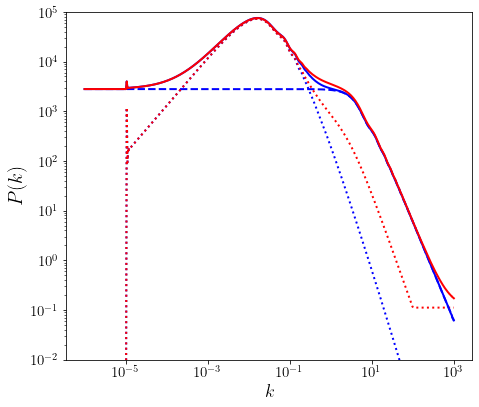

In [11]:
fig, ax = pl.subplots(1,1, figsize = (7,6))
indz = np.where(PS.z_array > 0.5)[0][0]
ax.plot(k_array,Pk1h[indz,:], color='b',lw=2,ls='--')
ax.plot(k_array,Pk2h_lin[indz,:], color='b',lw=2,ls=':')
ax.plot(k_array,Pk2h_nl[indz,:], color='r',lw=2,ls=':')
ax.plot(k_array,(Pk1h+Pk2h_lin)[indz,:], color='b',lw=2,ls='-')
ax.plot(k_array,(Pk1h+Pk2h_nl)[indz,:], color='r',lw=2,ls='-')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$k$', size = 18)
ax.set_ylabel(r'$P(k)$', size = 20)
ax.set_ylim(1e-2,1e5)
# ax.set_xlim(0.0,1.0)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.legend(fontsize = 18, frameon = False)
pl.tight_layout()




No handles with labels found to put in legend.


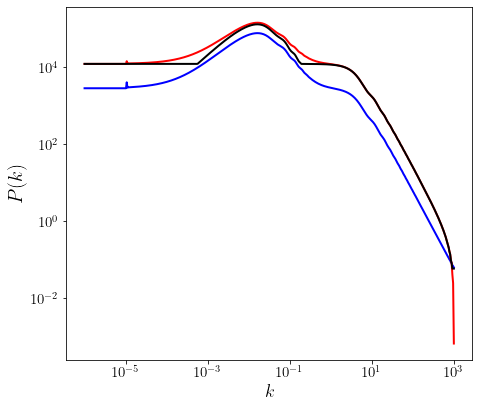

In [12]:
fig, ax = pl.subplots(1,1, figsize = (7,6))
indz = np.where(PS.z_array > 0.5)[0][0]
# ax.plot(k_array,Pk1h_cg[indz,:], color='b',lw=2,ls='--')
# ax.plot(k_array,Pk2h_lin[indz,:], color='b',lw=2,ls=':')
# ax.plot(k_array,Pk2h_nl[indz,:], color='r',lw=2,ls=':')
ax.plot(k_array,(Pk1h+Pk2h_lin)[indz,:], color='b',lw=2,ls='-')
ax.plot(k_array,(Pk1h_cg+Pk2h_cg_lin)[indz,:] - Pk1h_cg[indz,-1], color='r',lw=2,ls='-')
ax.plot(k_array,np.maximum(Pk1h_cg[indz,:] - Pk1h_cg[indz,-1],Pk2h_cg_nl[indz,:]), color='k',lw=2,ls='-')

# ax.plot(k_array,(Pk1h+Pk2h_nl)[indz,:], color='r',lw=2,ls='-')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$k$', size = 18)
ax.set_ylabel(r'$P(k)$', size = 20)
# ax.set_ylim(1e-2,1e6)
# ax.set_ylim(95,96)
# ax.set_xlim(10,1001)
# ax.set_xlim(0.0,1.0)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.legend(fontsize = 18, frameon = False)
pl.tight_layout()





No handles with labels found to put in legend.


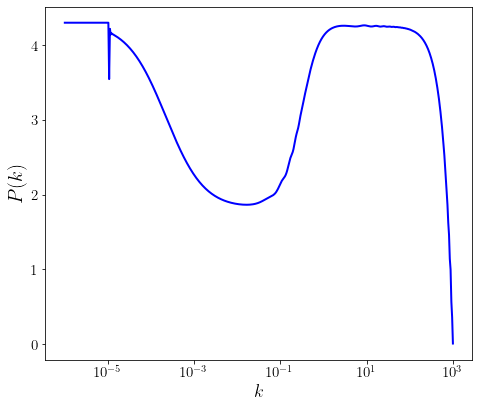

In [13]:
fig, ax = pl.subplots(1,1, figsize = (7,6))
indz = np.where(PS.z_array > 0.5)[0][0]
# ax.plot(k_array,Pk1h_cg[indz,:], color='b',lw=2,ls='--')
# ax.plot(k_array,Pk2h_lin[indz,:], color='b',lw=2,ls=':')
# ax.plot(k_array,Pk2h_nl[indz,:], color='r',lw=2,ls=':')
ax.plot(k_array,((Pk1h_cg+Pk2h_cg_lin)[indz,:] - Pk1h_cg[indz,-1])/(Pk1h+Pk2h_lin)[indz,:], color='b',lw=2,ls='-')
# ax.plot(k_array,(Pk1h_cg+Pk2h_cg_lin)[indz,:], color='r',lw=2,ls='-')
# ax.plot(k_array,(Pk1h+Pk2h_nl)[indz,:], color='r',lw=2,ls='-')

ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel(r'$k$', size = 18)
ax.set_ylabel(r'$P(k)$', size = 20)
# ax.set_ylim(1.1,1.6)
# ax.set_xlim(0.0,1.0)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.legend(fontsize = 18, frameon = False)
pl.tight_layout()





In [14]:
from mcfit import P2xi
from mcfit import xi2P
import scipy.interpolate as interpolate

k_array_hres = np.logspace(-6,3,100000)
# xi1h_mat = np.zeros((Pk1h.shape[0], len(k_array_hres)))
# xi2h_lin_mat = np.zeros((Pk1h.shape[0], len(k_array_hres)))
# xi2h_nl_mat = np.zeros((Pk1h.shape[0], len(k_array_hres)))
# xitot_lin_mat = np.zeros((Pk1h.shape[0], len(k_array_hres)))
xitot_lin_mat = np.zeros((Pk1h.shape[0], len(k_array)))

for jz in range(len(PS.z_array)):
#     Pk_intp = interpolate.interp1d(np.log(k_array), np.log(Pk1h[jz,:]), fill_value='extrapolate')
#     Pk = np.exp(Pk_intp(np.log(k_array_hres)))
#     r, xi = P2xi(k_array_hres)(Pk)
#     xi1h_mat[jz,:] = xi
#     Pk_intp = interpolate.interp1d(np.log(k_array), np.log(Pk2h_lin[jz,:]), fill_value='extrapolate')
#     Pk = np.exp(Pk_intp(np.log(k_array_hres)))
#     r, xi = P2xi(k_array_hres)(Pk)
#     xi2h_lin_mat[jz,:] = xi
#     Pk_intp = interpolate.interp1d(np.log(k_array), np.log(Pk2h_nl[jz,:]), fill_value='extrapolate')
#     Pk = np.exp(Pk_intp(np.log(k_array_hres)))
#     r, xi = P2xi(k_array_hres)(Pk)
#     xi2h_nl_mat[jz,:] = xi

#     Pk_intp = interpolate.interp1d(np.log(k_array), np.log(Pk1h[jz,:] + Pk2h_lin[jz,:]), fill_value='extrapolate')
#     Pk = np.exp(Pk_intp(np.log(k_array_hres)))
#     r, xi = P2xi(k_array_hres)(Pk)
    r, xi = P2xi(k_array)(Pk1h[jz,:] + Pk2h_lin[jz,:])
    xitot_lin_mat[jz,:] = xi
    


/global/u1/s/spandey/self_module_ini/myenv3/lib/python3.7/site-packages/mcfit/mcfit.py:126: UserWarning: The default value of lowring has been changed to False, set it to True if you cannot reproduce previous results
  warnings.warn("The default value of lowring has been changed to False, "
/global/u1/s/spandey/self_module_ini/myenv3/lib/python3.7/site-packages/mcfit/mcfit.py:217: UserWarning: The default value of extrap has been changed to False, set it to True if you cannot reproduce previous results
  warnings.warn("The default value of extrap has been changed to False, "


In [15]:
from mcfit import P2xi
from mcfit import xi2P
import scipy.interpolate as interpolate

k_array_hres = np.logspace(-4.8,np.log10(1000),100000)
# xi1h_cg_mat = np.zeros((Pk1h_cg.shape[0], len(k_array_hres)))
# xi2h_cg_lin_mat = np.zeros((Pk1h_cg.shape[0], len(k_array_hres)))
# xi2h_cg_nl_mat = np.zeros((Pk1h_cg.shape[0], len(k_array_hres)))
# xitot_cg_lin_mat = np.zeros((Pk1h_cg.shape[0], len(k_array_hres)))
xitot_cg_lin_mat = np.zeros((Pk1h_cg.shape[0], len(k_array)))

for jz in range(len(PS.z_array)):
#     print(jz)
#     Pk_intp = interpolate.interp1d(np.log(k_array), np.log(Pk1h_cg[jz,:] - Pk1h_cg[jz,-1]), fill_value='extrapolate')
#     Pk = np.exp(Pk_intp(np.log(k_array_hres)))
#     r, xi = P2xi(k_array_hres)(Pk)
#     xi1h_cg_mat[jz,:] = xi
#     Pk_intp = interpolate.interp1d(np.log(k_array), np.log(Pk2h_cg_lin[jz,:]), fill_value='extrapolate')
#     Pk = np.exp(Pk_intp(np.log(k_array_hres)))
#     r, xi = P2xi(k_array_hres)(Pk)
#     xi2h_cg_lin_mat[jz,:] = xi
#     Pk_intp = interpolate.interp1d(np.log(k_array), np.log(Pk2h_cg_nl[jz,:]), fill_value='extrapolate')
#     Pk = np.exp(Pk_intp(np.log(k_array_hres)))
#     r, xi = P2xi(k_array_hres)(Pk)
#     xi2h_cg_nl_mat[jz,:] = xi

#     Pk_intp = interpolate.interp1d(np.log(k_array), np.log(Pk1h_cg[jz,:] + Pk2h_cg_lin[jz,:]), fill_value='extrapolate')
#     Pk = np.exp(Pk_intp(np.log(k_array_hres)))
#     r, xi = P2xi(k_array_hres)(Pk)
    r, xi = P2xi(k_array)(Pk1h_cg[jz,:] + Pk2h_cg_lin[jz,:] - Pk1h_cg[jz,-1])
    xitot_cg_lin_mat[jz,:] = xi    

    

In [16]:
from mcfit import P2xi
from mcfit import xi2P
import scipy.interpolate as interpolate

k_array_hres = np.logspace(-4.8,np.log10(1000),100000)
alpha = 0.7
xitot_cg_lin_mat_smooth = np.zeros((Pk1h_cg.shape[0], len(k_array)))

for jz in range(len(PS.z_array)):

    r, xi = P2xi(k_array)( ((Pk1h_cg[jz,:] - Pk1h_cg[jz,-1])**(alpha) + (Pk2h_cg_lin[jz,:])**(alpha))**(1/alpha) )
    xitot_cg_lin_mat_smooth[jz,:] = xi    

    

In [17]:
from mcfit import P2xi
from mcfit import xi2P
import scipy.interpolate as interpolate

k_array_hres = np.logspace(-4.8,np.log10(1000),100000)
alpha = 0.5
xitot_cg_lin_mat_smooth2 = np.zeros((Pk1h_cg.shape[0], len(k_array)))

for jz in range(len(PS.z_array)):

    r, xi = P2xi(k_array)( ((Pk1h_cg[jz,:] - Pk1h_cg[jz,-1])**(alpha) + (Pk2h_cg_lin[jz,:])**(alpha))**(1/alpha) )
    xitot_cg_lin_mat_smooth2[jz,:] = xi    

    

In [18]:
from mcfit import P2xi
from mcfit import xi2P
import scipy.interpolate as interpolate

k_array_hres = np.logspace(-4.8,np.log10(1000),100000)
alpha = 0.5
xitot_cg_lin_mat_maxfp = np.zeros((Pk1h_cg.shape[0], len(k_array)))

for jz in range(len(PS.z_array)):
    Pk_tot = np.maximum(Pk1h_cg[jz,:] - Pk1h_cg[jz,-1],Pk2h_cg_nl[jz,:])
    r, xi = P2xi(k_array)(Pk_tot)
    xitot_cg_lin_mat_maxfp[jz,:] = xi    

    

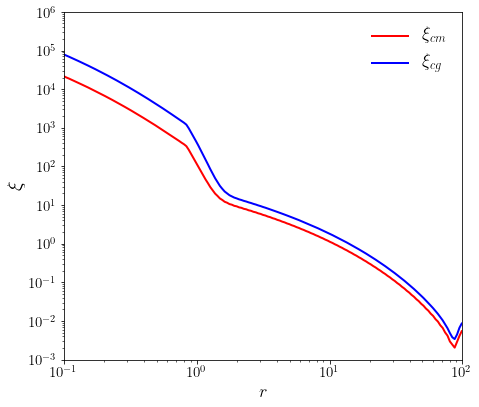

In [19]:
fig, ax = pl.subplots(1,1, figsize = (7,6))
indz = np.where(PS.z_array > 0.1)[0][0]
# ax.plot(r,xi1h_mat[indz,:], color='b',lw=2,ls='--')
# ax.plot(r,xi2h_lin_mat[indz,:], color='b',lw=2,ls=':')
# ax.plot(r,xi2h_nl_mat[indz,:], color='r',lw=2,ls=':')
# ax.plot(r,(xi1h_mat+xi2h_lin_mat)[indz,:], color='b',lw=2,ls='-')
ax.plot(r,(xitot_lin_mat)[indz,:], color='r',lw=2,ls='-',label=r'$\xi_{cm}$')
ax.plot(r,(xitot_cg_lin_mat)[indz,:], color='b',lw=2,ls='-',label=r'$\xi_{cg}$')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$r$', size = 18)
ax.set_ylabel(r'$\xi$', size = 20)
ax.set_ylim(1e-3,1e6)
ax.set_xlim(0.1,100)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.legend(fontsize = 18, frameon = False)
pl.tight_layout()





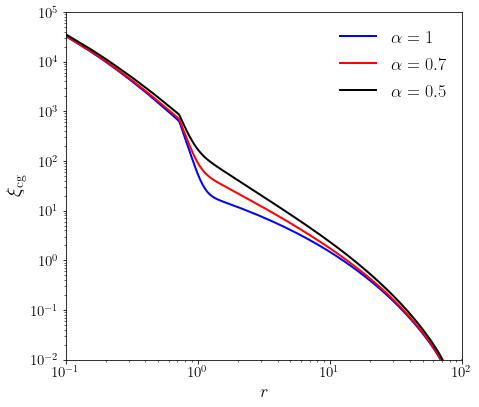

In [204]:
fig, ax = pl.subplots(1,1, figsize = (7,6))
indz = np.where(PS.z_array > 0.5)[0][0]

ax.plot(r,(xitot_cg_lin_mat)[indz,:], color='b',lw=2,ls='-',label=r'$\alpha=1$')
ax.plot(r,(xitot_cg_lin_mat_smooth)[indz,:], color='r',lw=2,ls='-',label=r'$\alpha=0.7$')
ax.plot(r,(xitot_cg_lin_mat_smooth2)[indz,:], color='k',lw=2,ls='-',label=r'$\alpha=0.5$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$r$', size = 18)
ax.set_ylabel(r'$\xi_{\rm cg}$', size = 20)
ax.set_ylim(1e-2,1e5)
ax.set_xlim(0.1,100)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.legend(fontsize = 18, frameon = False)
pl.tight_layout()



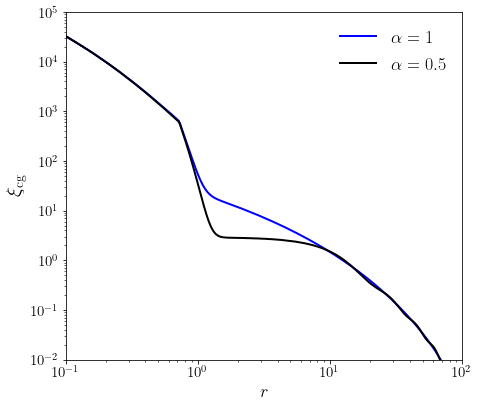

In [210]:
fig, ax = pl.subplots(1,1, figsize = (7,6))
indz = np.where(PS.z_array > 0.5)[0][0]

ax.plot(r,(xitot_cg_lin_mat)[indz,:], color='b',lw=2,ls='-',label=r'$\alpha=1$')
ax.plot(r,(xitot_cg_lin_mat_maxfp)[indz,:], color='k',lw=2,ls='-',label=r'$\alpha=0.5$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$r$', size = 18)
ax.set_ylabel(r'$\xi_{\rm cg}$', size = 20)
ax.set_ylim(1e-2,1e5)
ax.set_xlim(0.1,100)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.legend(fontsize = 18, frameon = False)
pl.tight_layout()



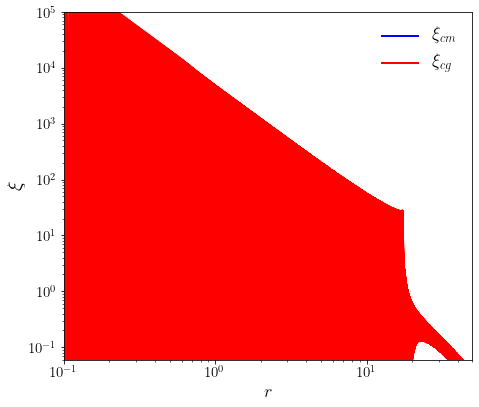

In [33]:
fig, ax = pl.subplots(1,1, figsize = (7,6))
indz = np.where(PS.z_array > 0.5)[0][0]
# ax.plot(r,xi1h_mat[indz,:], color='b',lw=2,ls='--')
# ax.plot(r,xi2h_lin_mat[indz,:], color='b',lw=2,ls=':')
# ax.plot(r,xi2h_nl_mat[indz,:], color='r',lw=2,ls=':')
ax.plot(r,(xitot_lin_mat)[indz,:], color='b',lw=2,ls='-',label=r'$\xi_{cm}$')
ax.plot(r,(xitot_cg_lin_mat)[indz,:], color='r',lw=2,ls='-',label=r'$\xi_{cg}$')
# ax.plot(k_array,(Pk1h+Pk2h_nl)[indz,:], color='r',lw=2,ls='-')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$r$', size = 18)
ax.set_ylabel(r'$\xi$', size = 20)
ax.set_ylim(6e-2,1e5)
ax.set_xlim(0.1,50)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.legend(fontsize = 18, frameon = False)
pl.tight_layout()





No handles with labels found to put in legend.


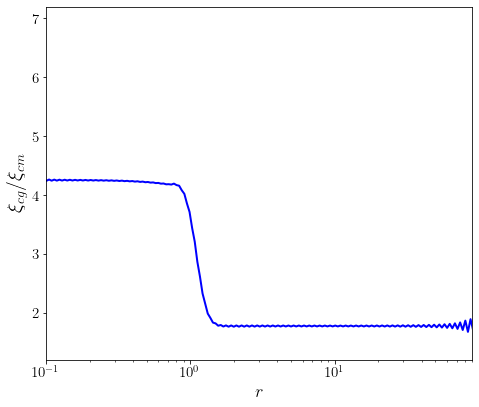

In [380]:
fig, ax = pl.subplots(1,1, figsize = (7,6))
indz = np.where(PS.z_array > 0.5)[0][0]
# ax.plot(r,xi1h_mat[indz,:], color='b',lw=2,ls='--')
# ax.plot(r,xi2h_lin_mat[indz,:], color='b',lw=2,ls=':')
# ax.plot(r,xi2h_nl_mat[indz,:], color='r',lw=2,ls=':')
ax.plot(r,((xitot_cg_lin_mat)[indz,:])/(xitot_lin_mat)[indz,:], color='b',lw=2,ls='-')
# ax.plot(r,, color='r',lw=2,ls='-')
# ax.plot(k_array,(Pk1h+Pk2h_nl)[indz,:], color='r',lw=2,ls='-')

ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel(r'$r$', size = 18)
ax.set_ylabel(r'$\xi_{cg}/\xi_{cm}$', size = 20)
# ax.set_ylim(1e-3,1e6)
ax.set_ylim(1.2,7.2)
ax.set_xlim(0.1,90)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.legend(fontsize = 18, frameon = False)
pl.tight_layout()





In [319]:
PS.rho_m_bar/1e12


0.08520374456380249

In [320]:
from mcfit import P2xi
from mcfit import xi2P
import scipy.interpolate as interpolate
from mcfit import Hankel
k_array_hres = np.logspace(-4.8,np.log10(1000),100000)

wprp_tot_mat = np.zeros((Pk1h.shape[0], len(k_array) - 1))
Deltawprp_tot_mat = np.zeros((Pk1h.shape[0], len(k_array) - 1))
units = PS.rho_m_bar

for jz in range(len(PS.z_array)):
    rp_out, wprp_out = Hankel(k_array, nu=0, q=1.0)(Pk1h[jz,:] + Pk2h_lin[jz,:], extrap=True)
    wprp_out *= (1 / (2 * np.pi))
    drp_out = rp_out[1:] - rp_out[:-1]
    rp_cen = 0.5*(rp_out[1:] + rp_out[:-1])
    
    wprp_cen = 0.5*(wprp_out[1:] + wprp_out[:-1])*(PS.rho_m_bar/1e12)
    wprp_tot_mat[jz,:] = wprp_cen
    
    wprp_ltr = (2./(rp_cen**2))*np.cumsum(drp_out * rp_cen * wprp_cen)
    Deltawprp_tot_mat[jz,:] = wprp_ltr - wprp_cen

    

In [321]:
1e4/(1e6)




0.01

In [294]:
from mcfit import P2xi
from mcfit import xi2P
import scipy.interpolate as interpolate
from mcfit import Hankel
k_array_hres = np.logspace(-4.8,np.log10(1000),100000)

# wprp_tot_mat = np.zeros((Pk1h.shape[0], len(k_array) - 1))
Sigmag_tot_mat = np.zeros((Pk1h.shape[0], len(k_array) - 1))
# units = PS.rho_m_bar

for jz in range(len(PS.z_array)):
    rp_out, wprp_out = Hankel(k_array, nu=0, q=1.0)(Pk1h_cg[jz,:] + Pk2h_cg_lin[jz,:] - Pk1h_cg[jz,-1], extrap=True)
    wprp_out *= (1 / (2 * np.pi))
    drp_out = rp_out[1:] - rp_out[:-1]
    rp_cen = 0.5*(rp_out[1:] + rp_out[:-1])
    
    wprp_cen = 0.5*(wprp_out[1:] + wprp_out[:-1])
    Sigmag_tot_mat[jz,:] = wprp_cen * nbarg_array[jz]
    
    
    

In [295]:
from mcfit import P2xi
from mcfit import xi2P
import scipy.interpolate as interpolate
from mcfit import Hankel
k_array_hres = np.logspace(-4.8,np.log10(1000),100000)
alpha1=0.7
alpha2 = 0.5
Sigmag_tot_mat_smooth1 = np.zeros((Pk1h.shape[0], len(k_array) - 1))
Sigmag_tot_mat_smooth2 = np.zeros((Pk1h.shape[0], len(k_array) - 1))

for jz in range(len(PS.z_array)):
    rp_out, wprp_out = Hankel(k_array, nu=0, q=1.0)( ((Pk1h_cg[jz,:] - Pk1h_cg[jz,-1])**(alpha1) + (Pk2h_cg_lin[jz,:])**(alpha1))**(1/alpha1) , extrap=True)
    wprp_out *= (1 / (2 * np.pi))
    drp_out = rp_out[1:] - rp_out[:-1]
    rp_cen = 0.5*(rp_out[1:] + rp_out[:-1])
    
    wprp_cen = 0.5*(wprp_out[1:] + wprp_out[:-1])
    Sigmag_tot_mat_smooth1[jz,:] = wprp_cen * nbarg_array[jz]
    
    rp_out, wprp_out = Hankel(k_array, nu=0, q=1.0)( ((Pk1h_cg[jz,:] - Pk1h_cg[jz,-1])**(alpha2) + (Pk2h_cg_lin[jz,:])**(alpha2))**(1/alpha2) , extrap=True)
    wprp_out *= (1 / (2 * np.pi))
    drp_out = rp_out[1:] - rp_out[:-1]
    rp_cen = 0.5*(rp_out[1:] + rp_out[:-1])
    
    wprp_cen = 0.5*(wprp_out[1:] + wprp_out[:-1])
    Sigmag_tot_mat_smooth2[jz,:] = wprp_cen * nbarg_array[jz]   
    
    
    

In [296]:
from mcfit import P2xi
from mcfit import xi2P
import scipy.interpolate as interpolate
from mcfit import Hankel
k_array_hres = np.logspace(-4.8,np.log10(1000),100000)

# wprp_tot_mat = np.zeros((Pk1h.shape[0], len(k_array) - 1))
Sigmag_tot_mat_1h = np.zeros((Pk1h.shape[0], len(k_array) - 1))
Sigmag_tot_mat_2h = np.zeros((Pk1h.shape[0], len(k_array) - 1))
# units = PS.rho_m_bar

for jz in range(len(PS.z_array)):
    rp_out, wprp_out = Hankel(k_array, nu=0, q=1.0)(Pk1h_cg[jz,:] - Pk1h_cg[jz,-1], extrap=True)
    wprp_out *= (1 / (2 * np.pi))
    drp_out = rp_out[1:] - rp_out[:-1]
    rp_cen = 0.5*(rp_out[1:] + rp_out[:-1])
    
    wprp_cen = 0.5*(wprp_out[1:] + wprp_out[:-1])
    Sigmag_tot_mat_1h[jz,:] = wprp_cen* nbarg_array[jz]  

    rp_out, wprp_out = Hankel(k_array, nu=0, q=1.0)(Pk2h_cg_nl[jz,:] , extrap=True)
    wprp_out *= (1 / (2 * np.pi))
    drp_out = rp_out[1:] - rp_out[:-1]
    rp_cen = 0.5*(rp_out[1:] + rp_out[:-1])
    
    wprp_cen = 0.5*(wprp_out[1:] + wprp_out[:-1])
    Sigmag_tot_mat_2h[jz,:] = wprp_cen    * nbarg_array[jz]  
    
    

No handles with labels found to put in legend.


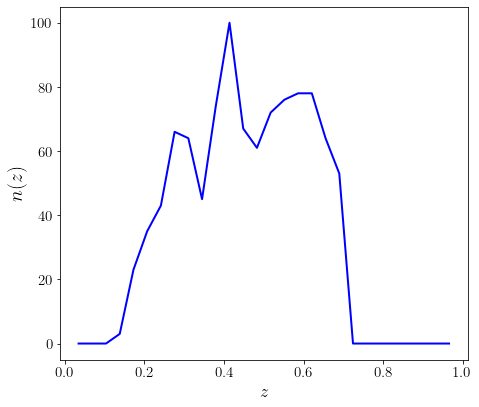

In [151]:
dfc = np.load('advact_SNRgt4_z0.15-0.7_redshifts.npz')
# list(dfc.keys())
bin_min = 0.0
bin_max = 1.0
nbins_hist = 30
delta_bin = (bin_max - bin_min) / nbins_hist
bin_centers_all = np.linspace(bin_min, bin_max, nbins_hist)
bin_edges = (bin_centers_all[1:] + bin_centers_all[:-1])/2.
bin_centers = bin_centers_all[1:-1]

nz_hist, z_edges = np.histogram(dfc['z'], bins=bin_edges)

fig, ax = pl.subplots(1,1, figsize = (7,6))

ax.plot(bin_centers,nz_hist, color='b',lw=2,ls='-')
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel(r'$z$', size = 18)
ax.set_ylabel(r'$n(z)$', size = 20)
# ax.set_ylim(1e-3,1e6)
# ax.set_ylim(1.2,1.8)
# ax.set_xlim(0.01,100)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.legend(fontsize = 18, frameon = False)
pl.tight_layout()




In [322]:
nz_interp = interpolate.interp1d(bin_centers,nz_hist)
nz_array = nz_interp(PS.z_array)
nz_mat = np.tile(nz_array.reshape(len(PS.z_array),1),(1,len(k_array) - 1))

DeltaSigma_cm_tot_norm = sp.integrate.simps((nz_mat*Deltawprp_tot_mat).T,PS.z_array )/sp.integrate.simps((nz_mat).T,PS.z_array)

# 




In [298]:
Sigma_cg_tot_norm = sp.integrate.simps((nz_mat*Sigmag_tot_mat).T,PS.z_array )/sp.integrate.simps((nz_mat).T,PS.z_array)

Sigma_cg_tot_norm_smooth1 = sp.integrate.simps((nz_mat*Sigmag_tot_mat_smooth1).T,PS.z_array )/sp.integrate.simps((nz_mat).T,PS.z_array)

Sigma_cg_tot_norm_smooth2 = sp.integrate.simps((nz_mat*Sigmag_tot_mat_smooth2).T,PS.z_array )/sp.integrate.simps((nz_mat).T,PS.z_array)




In [299]:
Sigma_cg_tot_norm_1h = sp.integrate.simps((nz_mat*Sigmag_tot_mat_1h).T,PS.z_array )/sp.integrate.simps((nz_mat).T,PS.z_array)

Sigma_cg_tot_norm_2h = sp.integrate.simps((nz_mat*Sigmag_tot_mat_2h).T,PS.z_array )/sp.integrate.simps((nz_mat).T,PS.z_array)

Sigma_cg_tot_maxr = np.maximum(Sigmag_tot_mat_2h,Sigmag_tot_mat_1h)
Sigma_cg_tot_norm_tot_maxr = sp.integrate.simps((nz_mat*Sigma_cg_tot_maxr).T,PS.z_array )/sp.integrate.simps((nz_mat).T,PS.z_array)



In [153]:
df1 = np.load('/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis/ACTxDESY3/src/plotting/dsigma_advact_SNRgt4_z0.15-0.70_NR18_0.2-60.0_bpz.npz')  
df2 = np.load('/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis/ACTxDESY3/src/plotting/boost_advact_SNRgt4_z0.15-0.70_NR18_0.2-60.0_bpz.npz')

list(df2.keys())



['boost', 'cov']

In [154]:
# list(df2.keys())
# df1['dsigma'].shape, df1['boost'].shape, df2['boost'].shape

dsig_data = df1['dsigma']*df2['boost']
rp_data = np.logspace(np.log10(0.2),np.log10(60),18)
sig_data = np.sqrt(np.diag(df1['cov'] + df2['cov']))



In [219]:
df2 = np.loadtxt('NHOD_0.60_1.200_-13.70_0.90_1.20_0.00_0.00_1.00_1.00_10.00_0.83_-5.52_0.40_0.00_67.3_0.template_param.ave.delsig_cm.del8g.txt')

df2.shape


(20, 4)

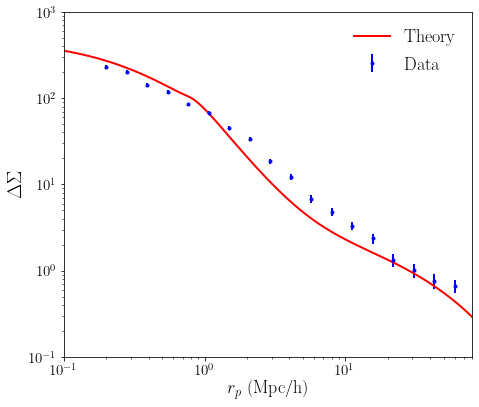

In [384]:
fig, ax = pl.subplots(1,1, figsize = (7,6))
# indz = np.where(PS.z_array > 0.7)[0][0]
# ax.plot(rp_cen,(wprp_tot_mat)[indz,:], color='r',lw=2,ls='-')
ax.plot(rp_cen,(DeltaSigma_cm_tot_norm), color='r',lw=2,ls='-',label='Theory')
ax.errorbar(rp_data,dsig_data, sig_data,color='b',lw=2,ls='',marker='o',ms=3.0,label='Data')
# ax.plot(0.5*(df2[:,0] + df2[:,1]),1.5*df2[:,3], color='k',lw=2,ls='-')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$r_p$ (Mpc/h)', size = 18)
ax.set_ylabel(r'$\Delta \Sigma$', size = 20)
ax.set_ylim(1e-1,1e3)
ax.set_xlim(0.1,80)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.legend(fontsize = 18, frameon = False)
pl.tight_layout()





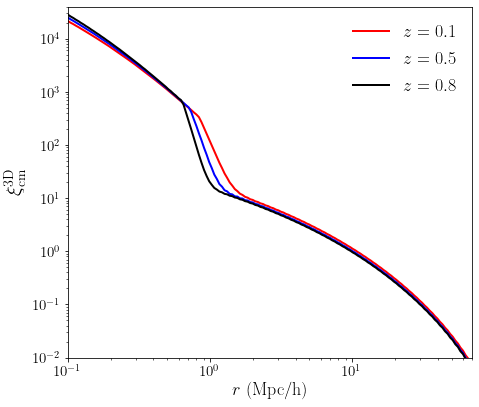

In [399]:
fig, ax = pl.subplots(1,1, figsize = (7,6))
indz = np.where(PS.z_array > 0.1)[0][0]
ax.plot(r,(xitot_lin_mat)[indz,:], color='r',lw=2,ls='-',label=r'$z=0.1$')
indz = np.where(PS.z_array > 0.5)[0][0]
ax.plot(r,(xitot_lin_mat)[indz,:], color='b',lw=2,ls='-',label=r'$z=0.5$')
indz = np.where(PS.z_array > 0.79)[0][0]
ax.plot(r,(xitot_lin_mat)[indz,:], color='k',lw=2,ls='-',label=r'$z=0.8$')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$r$ (Mpc/h)', size = 18)
ax.set_ylabel(r'$\xi^{\rm 3D}_{\rm cm}$', size = 20)
ax.set_ylim(1e-2,4e4)
ax.set_xlim(0.1,70)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.legend(fontsize = 18, frameon = False)
pl.tight_layout()





In [183]:
df1 = np.load('Sig_advact_all_SNRgt4.0_nR25_0.14-85.71_z0.15-0.70_maglim22.5.npz')
rp_data2 = np.logspace(np.log10(0.1),np.log10(60),25)
list(df1.keys())
# sig_cg_data = df1['Sigma']
# xi_cg_data = df1['Xi']


['cov_Xi', 'Xi', 'Sigma', 'cov']

In [182]:
df1.keys()


KeysView(<numpy.lib.npyio.NpzFile object at 0x2aaae35da510>)

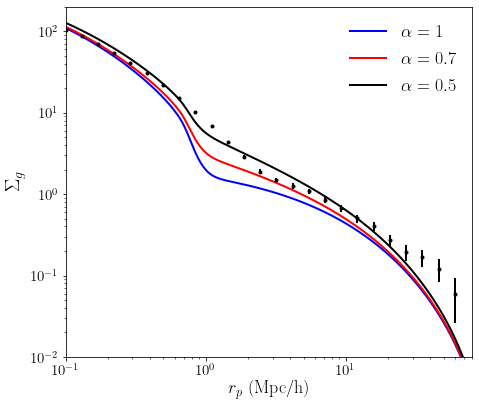

In [279]:
fig, ax = pl.subplots(1,1, figsize = (7,6))
# indz = np.where(PS.z_array > 0.7)[0][0]
# ax.plot(rp_cen,(wprp_tot_mat)[indz,:], color='r',lw=2,ls='-')
ax.plot(rp_cen,(Sigma_cg_tot_norm), color='b',lw=2,ls='-',label=r'$\alpha=1$')
ax.plot(rp_cen,(Sigma_cg_tot_norm_smooth1), color='r',lw=2,ls='-',label=r'$\alpha=0.7$')
ax.plot(rp_cen,(Sigma_cg_tot_norm_smooth2), color='k',lw=2,ls='-',label=r'$\alpha=0.5$')
# ax.errorbar(rp_data2,xi_cg_data,color='b',lw=2,ls='',marker='o',ms=3.0)
ax.errorbar(rp_data2,sig_cg_data, np.sqrt(np.diag(df1['cov'])),color='k',lw=2,ls='',marker='o',ms=3.0)


ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$r_p$ (Mpc/h)', size = 18)
ax.set_ylabel(r'$\Sigma_g$', size = 20)
ax.set_ylim(1e-2,2e2)
ax.set_xlim(0.1,80)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.legend(fontsize = 18, frameon = False)
pl.tight_layout()





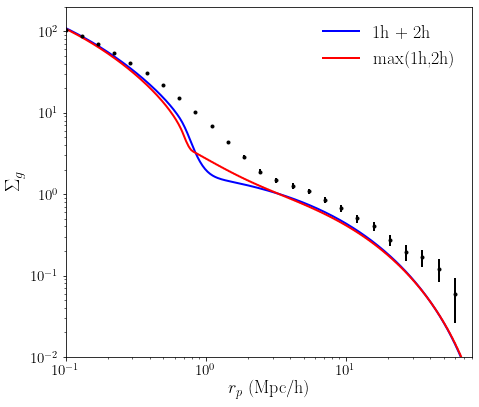

In [280]:
fig, ax = pl.subplots(1,1, figsize = (7,6))
# indz = np.where(PS.z_array > 0.7)[0][0]
# ax.plot(rp_cen,(wprp_tot_mat)[indz,:], color='r',lw=2,ls='-')
ax.plot(rp_cen,(Sigma_cg_tot_norm), color='b',lw=2,ls='-',label=r'1h + 2h')
ax.plot(rp_cen,(Sigma_cg_tot_norm_tot_maxr), color='r',lw=2,ls='-',label=r'max(1h,2h)')
# ax.plot(rp_cen,(1/80)*(Sigma_cg_tot_norm_smooth2), color='k',lw=2,ls='-',label=r'$\alpha=0.5$')
# ax.errorbar(rp_data2,xi_cg_data,color='b',lw=2,ls='',marker='o',ms=3.0)
ax.errorbar(rp_data2,sig_cg_data, np.sqrt(np.diag(df1['cov'])),color='k',lw=2,ls='',marker='o',ms=3.0)


ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$r_p$ (Mpc/h)', size = 18)
ax.set_ylabel(r'$\Sigma_g$', size = 20)
ax.set_ylim(1e-2,2e2)
ax.set_xlim(0.1,80)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.legend(fontsize = 18, frameon = False)
pl.tight_layout()





In [381]:
from mcfit import P2xi
from mcfit import xi2P
import scipy.interpolate as interpolate
from mcfit import Hankel
k_array_hres = np.logspace(-4.8,np.log10(1000),100000)

# wprp_tot_mat = np.zeros((Pk1h.shape[0], len(k_array) - 1))
num_mat = np.zeros(((len(k_array) - 1),Pk1h.shape[0]))
# units = PS.rho_m_bar
nz_array = nz_interp(PS.z_array)/sp.integrate.simps(nz_interp(PS.z_array),PS.z_array)
for jz in range(len(PS.z_array)):
    rp_out, wprp_out = Hankel(k_array, nu=0, q=1.0)(Pk1h_cg[jz,:] + Pk2h_cg_lin[jz,:] - Pk1h_cg[jz,-1], extrap=True)
    wprp_out *= (1 / (2 * np.pi))
    drp_out = rp_out[1:] - rp_out[:-1]
    rp_cen = 0.5*(rp_out[1:] + rp_out[:-1])
    
    wprp_cen = 0.5*(wprp_out[1:] + wprp_out[:-1])
    num_mat[:,jz] = wprp_cen * nbarg_array[jz] * (PS.chi_array[jz] ** 2) * (nz_array[jz])

num_final = sp.integrate.simps(num_mat,PS.z_array)
denom_final = sp.integrate.simps(nbarg_array,PS.chi_array)
N_tot = sp.integrate.simps(nbarg_array * (PS.chi_array[jz] ** 2),PS.chi_array )
Sigma_g_measure = num_final*denom_final/N_tot


    

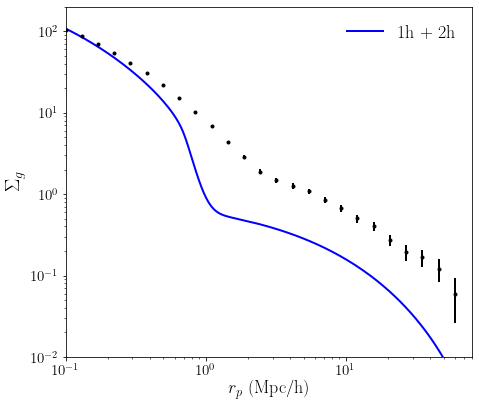

In [382]:
fig, ax = pl.subplots(1,1, figsize = (7,6))
# indz = np.where(PS.z_array > 0.7)[0][0]
# ax.plot(rp_cen,(wprp_tot_mat)[indz,:], color='r',lw=2,ls='-')
ax.plot(rp_cen,(Sigma_g_measure), color='b',lw=2,ls='-',label=r'1h + 2h')
# ax.plot(rp_cen,(Sigma_cg_tot_norm_tot_maxr), color='r',lw=2,ls='-',label=r'max(1h,2h)')
# ax.plot(rp_cen,(1/80)*(Sigma_cg_tot_norm_smooth2), color='k',lw=2,ls='-',label=r'$\alpha=0.5$')
# ax.errorbar(rp_data2,xi_cg_data,color='b',lw=2,ls='',marker='o',ms=3.0)
ax.errorbar(rp_data2,sig_cg_data, np.sqrt(np.diag(df1['cov'])),color='k',lw=2,ls='',marker='o',ms=3.0)


ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$r_p$ (Mpc/h)', size = 18)
ax.set_ylabel(r'$\Sigma_g$', size = 20)
ax.set_ylim(1e-2,2e2)
ax.set_xlim(0.1,80)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.legend(fontsize = 18, frameon = False)
pl.tight_layout()





In [68]:
nx = 50
nm = 80
nz = 1
x_array = np.linspace(0.1,4,nx)
M_array = np.logspace(10,16,nm)
Mmat = np.array([M_array])
zarr = np.array([0.193])
rho_crit = cosmo_colossus.rho_c(zarr) * (1000 ** 3)
R_mat = hmf.get_R_from_M_mat(Mmat,200*rho_crit)

y3d_mat = Pfid.get_y3d(Mmat, x_array, zarr, R_mat, M200c_mat=Mmat, mdef_M_mat='200c')

# nz, nm, nx = 1, 1, len(x_array)
x_mat = np.tile(x_array.reshape(1, 1, nx), (nz, nm, 1))

chi_array = hmf.get_Dcom_array(zarr, cosmo_params_dict['Om0'])
DA_array = chi_array / (1. + zarr)

DA_mat_coeff = np.tile(DA_array.reshape(nz, 1), (1, nm))
rmdefP_mat_coeff = R_mat
lmdefP_mat_coeff = DA_mat_coeff / rmdefP_mat_coeff

x_mat_lmdefP_mat = x_mat / np.tile(lmdefP_mat_coeff.reshape(nz, nm, 1), (1, 1, nx))
coeff_mat_y = 4 * np.pi * rmdefP_mat_coeff / (lmdefP_mat_coeff ** 2)

x_mat2_y3d_mat = (x_mat ** 2) * y3d_mat
# ghmf = general_hm(cosmo_params_dict, pressure_params_dict, other_params_dict)
dndm_array, bm_array = get_dndm_bias(Mmat,zarr, '200c')



In [79]:
y3d_mat.shape


(1, 80, 50)

In [69]:
k_array = np.logspace(-5,2,100)
byk_array = np.zeros(len(k_array))
for jk in range(len(k_array)):
    lv = k_array[jk] * chi_array - 0.5
#     print(lv.shape)
#     temp_mat = k_array[jk] * (x_array * )
#     uyk_array_jk = sp.integrate.simps(x_mat2_y3d_mat * ) * 
    byk_array[jk] = sp.integrate.simps(dndm_array * bm_array, uyk_array_jk,M_array)
    
    
    

In [70]:
# other_params_dict.keys()

pklin = np.exp(other_params_dict['pkzlin_interp'].ev(zarr, np.log(k_array))) 


In [71]:
Mh = np.array([np.array([1e15])])
_, bmh = get_dndm_bias(Mh,zarr, '200c')
P_hy_2h = bmh * byk_array * pklin



In [72]:
from mcfit import P2xi
# r, xi = P2xi(k)(P)

rv, xi_hy_2h = P2xi(k_array)(P_hy_2h)



In [74]:
x_array = np.linspace(0.1,10,100)
# Mmat = np.array([np.array([1e15])])
# zarr = np.array([0.193])
# rho_crit = cosmo_colossus.rho_c(zarr) * (1000 ** 3)
Rh = hmf.get_R_from_M_mat(Mh,200*rho_crit)

y3dh = Pfid.get_y3d(Mh, x_array, zarr, Rh, M200c_mat=Mh, mdef_M_mat='200c')



In [75]:
y3dh


array([[[1.49200099e-04, 5.77088618e-05, 2.66971515e-05, 1.37513379e-05,
         7.65034036e-06, 4.51676971e-06, 2.79719780e-06, 1.80200460e-06,
         1.20012856e-06, 8.22345914e-07, 5.77544849e-07, 4.14465477e-07,
         3.03157647e-07, 2.25536157e-07, 1.70359148e-07, 1.30456388e-07,
         1.01148045e-07, 7.93157173e-08, 6.28420697e-08, 5.02646974e-08,
         4.05576406e-08, 3.29907350e-08, 2.70374202e-08, 2.23132997e-08,
         1.85345628e-08, 1.54894461e-08, 1.30183847e-08, 1.10000372e-08,
         9.34133289e-09, 7.97030663e-09, 6.83088886e-09, 5.87908099e-09,
         5.08012286e-09, 4.40637700e-09, 3.83573588e-09, 3.35041378e-09,
         2.93602375e-09, 2.58086769e-09, 2.27538685e-09, 2.01173373e-09,
         1.78343679e-09, 1.58513628e-09, 1.41237497e-09, 1.26143162e-09,
         1.12918778e-09, 1.01302064e-09, 9.10716664e-10, 8.20401475e-10,
         7.40482808e-10, 6.69603885e-10, 6.06605157e-10, 5.50492802e-10,
         5.00412690e-10, 4.55628794e-10, 4.15505235